In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path

df_all = pd.read_csv(Path("./data/train.csv"))
df_sub = pd.read_csv(Path("./data/test.csv"))
df_all.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_sub.head(2)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_all, y_all = df_all.iloc[:, 1:], df_all.iloc[:, 0]
X_all.head(2)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_all.head(2)

0    1
1    0
Name: label, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch
import torchvision
import tqdm

seed = 42
torch.manual_seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=seed)
t_y_train, t_y_test = torch.from_numpy(y_train.values), torch.from_numpy(y_test.values)
pipe = Pipeline(
    [
        ("scale", FunctionTransformer(func=lambda x: x.values / 255, inverse_func=lambda x: x * 255)),
        ("to_torch", FunctionTransformer(func=lambda x: torch.from_numpy(x))),
        ("reshape", FunctionTransformer(func=lambda x: x.view(-1, 1, 28, 28))),
    ]
)

t_X_train = pipe.transform(X_train)
t_X_test = pipe.transform(X_test)

transforms = torchvision.transforms.Compose(
    [
        # torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.4)),
        torchvision.transforms.RandomCrop(size=28, padding=3),
        # torchvision.transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
        torchvision.transforms.RandomAffine(degrees=20, translate=(0.0, 0.1)),
        torchvision.transforms.ElasticTransform(),
        # torchvision.transforms.RandomRotation(20),
    ]
)


class TransformedDataset(Dataset):
    def __init__(self, x_tensor: torch.Tensor, y_tensor: torch.Tensor, aug_factor: float = 1.0):
        # assert len(x_tensor.shape) == 4, "expected 4-D X data"
        # assert len(y_tensor.shape) == 1, "expected 1-D y data"
        assert x_tensor.size(0) == y_tensor.size(0), "Size mismatch between tensors"
        self.x_tensor = x_tensor
        self.y_tensor = y_tensor
        self.orig_size = x_tensor.shape[0]
        self.aug_size = int(aug_factor * x_tensor.shape[0])
        self.augmented_x = torch.empty(size=(self.aug_size, *x_tensor.shape[1:]))
        self.augmented_y = torch.empty(size=(self.aug_size,))
        for i in tqdm.trange(self.aug_size):
            self.augmented_x[i] = transforms(x_tensor[i % x_tensor.shape[0]])
            self.augmented_y[i] = y_tensor[i % y_tensor.shape[0]]

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        if index < self.orig_size:
            return self.x_tensor[index], self.y_tensor[index]
        return self.augmented_x[index - self.orig_size], self.augmented_y[index - self.orig_size]

    def __len__(self) -> int:
        return self.x_tensor.shape[0] + self.augmented_x.shape[0]


train_ds = TransformedDataset(t_X_train, t_y_train, aug_factor=6)
valid_ds = TensorDataset(t_X_test, t_y_test)
train_dl = DataLoader(train_ds, batch_size=1024 * 3, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=1024 * 3, shuffle=True)


100%|██████████| 201600/201600 [04:16<00:00, 786.40it/s]


In [7]:
from collections import OrderedDict


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            OrderedDict(
                # (w - ks + 2pad) / s + 1
                [
                    ("conv1", nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)),
                    ("act1", nn.Mish()),
                    ("bn1", nn.BatchNorm2d(num_features=64)),
                    ("mp1", nn.MaxPool2d(kernel_size=(2, 2))),
                    # 13
                    ("conv2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                    ("act2", nn.Mish()),
                    ("bn2", nn.BatchNorm2d(num_features=128)),
                    ("mp2", nn.MaxPool2d(kernel_size=(2, 2))),
                    # 5
                    ("flatten", nn.Flatten()),
                    ("fc1", nn.Linear(in_features=128 * 5 * 5, out_features=1024)),
                    ("ac3", nn.ReLU()),
                    ("ac3", nn.BatchNorm1d(num_features=1024)),
                    ("do1", nn.Dropout(p=0.5)),
                    ("fc2", nn.Linear(in_features=1024, out_features=10)),
                    ("sm", nn.Softmax()),
                ]
            )
        )

    def forward(self, x):
        return self.nn(x)


In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

acc_train, loss_train, acc_valid, loss_valid = [], [], [], []


def update_learning_curve(acc: float, loss: float, is_train: bool):
    if is_train:
        acc_train.append(acc)
        loss_train.append(loss)
    else:
        acc_valid.append(acc)
        loss_valid.append(loss)
    fig, ax = plt.subplots(1, 2, figsize=(16, 9))
    clear_output(wait=False)
    ax[0].plot(range(1, len(loss_train) + 1), loss_train, label="train")
    ax[0].plot(range(1, len(loss_valid) + 1), loss_valid, label="validation")
    ax[0].set_title(f"loss, last={None if not loss_valid else loss_valid[-1]}")
    ax[0].set_ylabel("loss")
    ax[1].plot(range(1, len(acc_train) + 1), acc_train, label="train")
    ax[1].plot(range(1, len(acc_valid) + 1), acc_valid, label="validation")
    ax[1].set_title(f"accuracy, last={None if not loss_valid else acc_valid[-1]}")
    for i in (0, 1):
        ax[i].legend()
        ax[i].grid()
        ax[i].set_xlabel("epoch")
    plt.show()


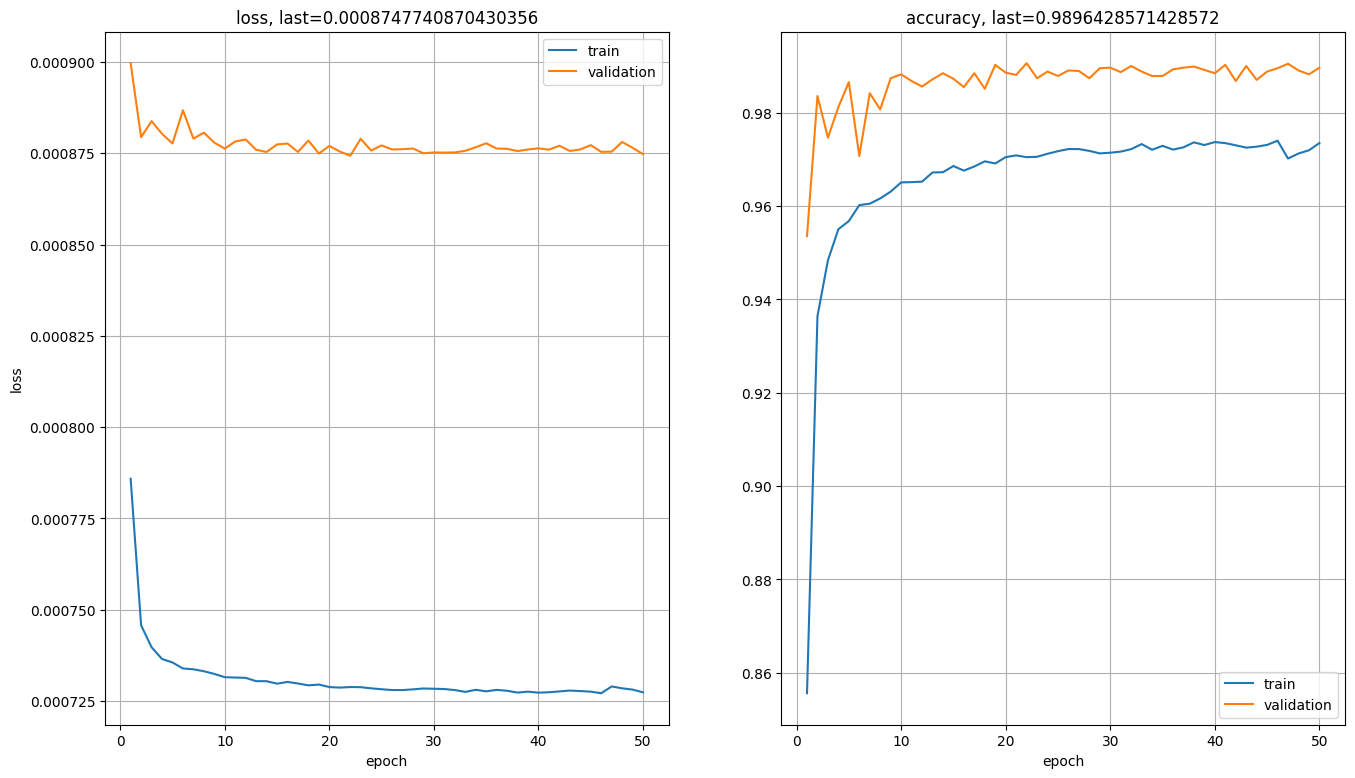

In [9]:
from torch.optim.lr_scheduler import StepLR

model = Net()
cirterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 50


acc_train, loss_train, acc_valid, loss_valid = [], [], [], []
for epoch in range(1, num_epochs + 1):
    model.train()
    model.cuda()
    train_correct, train_loss = 0, 0
    for i, (x, y) in enumerate(train_dl):
        x, y = x.cuda().float(), y.cuda().long()
        optimizer.zero_grad()
        pred = model(x)
        loss = cirterion(pred, y)
        loss.backward()
        optimizer.step()
        pred = torch.argmax(pred, dim=1).detach()
        train_correct += (pred == y).sum().item()
        train_loss += loss.item()
    train_correct /= len(train_ds)
    train_loss /= len(train_ds)
    update_learning_curve(acc=train_correct, loss=train_loss, is_train=True)

    # validate
    valid_correct, valid_loss = 0, 0
    with torch.no_grad():
        model.eval()
        for i, (x, y) in enumerate(valid_dl):
            x, y = x.cuda().float(), y.cuda().long()
            pred = model(x)
            loss = cirterion(pred, y)
            pred = torch.argmax(pred, dim=1).detach()
            valid_correct += (pred == y).sum().item()
            valid_loss += loss.item()
        valid_correct /= len(valid_ds)
        valid_loss /= len(valid_ds)
    update_learning_curve(acc=valid_correct, loss=valid_loss, is_train=False)

In [13]:
acc_valid[-1]


0.9896428571428572

In [14]:
model.eval()
with torch.no_grad():
    pred = torch.argmax(model.cpu()(pipe.transform(df_sub).float()), dim=-1)
pred


/home/kozharin/.cache/pypoetry/virtualenvs/kaggle-competitions-JUeE8WmT-py3.11/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([2, 0, 9,  ..., 3, 9, 2])

In [15]:
sample_df = pd.read_csv("data/sample_submission.csv", index_col=0)
sample_df["Label"] = pred.to("cpu").numpy()
sample_df.to_csv("data/submission.csv")